In [1]:
# load package
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.model_selection import learning_curve
# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Data Prepararion
# read data
train=pd.read_csv('train.csv',encoding='big5')
test=pd.read_csv('test.csv',encoding='big5')
submit=pd.read_csv('gender_submission.csv',encoding='big5')

In [3]:
# append in ONE data
data=train.append(test, ignore_index=True)

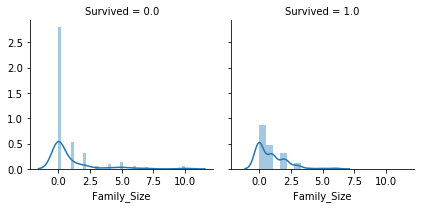

In [4]:
data['Family_Size']=data['Parch']+data['SibSp']
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數

In [5]:
#設法整理出「尊稱」這個因子
data['Title1']=data['Name'].str.split('.',expand=True)[0]
#expand=True是讓資料在dataframe展開欄位
#1是選第二項的title
# 切出尊稱
data['Title1']=data['Title1'].str.split(', ',expand=True)[1].str.strip()#[1]代表切出第2個'dlm'前面到第一個的字串
# 秀出dintinct後的title1
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [6]:
#合併成比較常出現的姓氏在Title2
data['Title2']=''
for idx, row in data.iterrows():  # 請務必記得加上idx，不然跑回圈的item會變成(idx, row)
    Sex = row['Sex']
    Title1=row['Title1']
    if Title1=='Master':
        Title2='Master'
    elif Title1=='Mrs':
        Title2='Mrs'
    elif Title1=='Miss':
        Title2='Miss'
    elif Sex=='male':
        Title2='Mr'
    else:
        Title2='Miss'
    data.loc[idx,'Title2']=Title2 #???
data['Title2'].unique()
tt2 = data.groupby(by='Title2', as_index=False).agg({'PassengerId': pd.Series.nunique})
tt2

,Title2,PassengerId
0,Master,61
1,Miss,269
2,Mr,782
3,Mrs,197


In [7]:
# 票的前幾碼代號可能有意義，流水編沒有所以拿掉
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [9]:
tt = data.groupby(by='Ticket_info', as_index=False).agg({'PassengerId': pd.Series.nunique})
tt.head()

,Ticket_info,PassengerId
0,A,1
1,A4,10
2,A5,28
3,AQ3,1
4,AQ4,1


In [10]:
tt['PassengerId'].describe()

count     37.000000
mean      35.378378
std      156.804434
min        1.000000
25%        1.000000
50%        4.000000
75%        9.000000
max      957.000000
Name: PassengerId, dtype: float64

In [11]:
#把count distinct的ticket_info低於第一四分位數的都改成None
tt['Ticket_info_rev']=tt['Ticket_info']
tt.Ticket_info_rev[tt.PassengerId<9]='None'
tt.head(4)

,Ticket_info,PassengerId,Ticket_info_rev
0,A,1,None
1,A4,10,A4
2,A5,28,A5
3,AQ3,1,None


In [12]:
#leftjoin Ticket_info_rev到大表
tt=tt.drop(['PassengerId'], axis=1)
data=pd.merge(left=data, right=tt,how='left', on=['Ticket_info', 'Ticket_info'])
data.head(4)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,Mr,Mr,A5,A5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,1,Mrs,Mrs,PC,PC
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,Miss,Miss,STONO2,None
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,Mrs,Mrs,X,X


In [13]:
# 抓船艙第一碼英文
# 送出kaggle成績沒有比較好，一堆空的也是合理
data['Cabin_info']=data['Cabin'].str[:1]
data['Cabin_info']=data['Cabin_info'].fillna('N')#空的補N
data['Cabin_info'].unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [14]:
'''
data['Cabin_info2']=data['Cabin_info']
data.Cabin_info2[data.Cabin_info in ('N','C')]='mm'
data.head()'''

"\ndata['Cabin_info2']=data['Cabin_info']\ndata.Cabin_info2[data.Cabin_info in ('N','C')]='mm'\ndata.head()"

In [15]:
#整併人數太少的cabin
#把'F','G','T'變成'Merged'
data['Cabin_info'].replace(['F','G','T'],'Merged',inplace=True)#inplace如果是false就是改爽的不會更動到值

In [16]:
#
print('Embarked原遺漏的人數：',data['Embarked'].isnull().sum())
#最多在S港上傳，填補遺漏值
data['Embarked']=data['Embarked'].fillna('S')

Embarked原遺漏的人數： 2


In [17]:
#
print('Fare原遺漏的人數：',data['Fare'].isnull().sum())
#用平均填補遺漏值
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

Fare原遺漏的人數： 1


In [18]:
#
print('Age原遺漏的人數：',data['Age'].isnull().sum())
#用中位數填補遺漏值
data['Age']=data['Age'].fillna(data['Age'].median())

Age原遺漏的人數： 263


In [34]:
#用(找是否有別名
data['NickName_ind']= data['Name'].str.contains('\(',na=False)*1

In [35]:
#留下準備get_dummies的欄位
for_dummy_data=data.drop(['Name','Cabin','Ticket','Ticket_info','Title1'], axis=1)
for_dummy_data.head(3)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Family_Size,Title2,Ticket_info_rev,Cabin_info,NickName_ind
0,22.0,S,7.2500,0,1,3,male,1,0.0,1,Mr,A5,N,0
1,38.0,C,71.2833,0,2,1,female,1,1.0,1,Mrs,PC,C,1
2,26.0,S,7.9250,0,3,3,female,0,1.0,0,Miss,None,N,0


In [36]:
data_dummies = pd.get_dummies(for_dummy_data)
#columns可以指定哪些欄位要get_dummies
data_dummies.head(3)
#data= pd.merge(left=data, right=data_dummies, how='left', left_on='PassengerId', right_on='PassengerId',)
#data.head(4)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Family_Size,NickName_ind,Embarked_C,...,Ticket_info_rev_STONO,Ticket_info_rev_WC,Ticket_info_rev_X,Cabin_info_A,Cabin_info_B,Cabin_info_C,Cabin_info_D,Cabin_info_E,Cabin_info_Merged,Cabin_info_N
0,22.0,7.2500,0,1,3,1,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,1,1,1.0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
2,26.0,7.9250,0,3,3,0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
data_dummies.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Sex_female', 'Sex_male', 'Title2_Master', 'Title2_Miss', 'Title2_Mr',
       'Title2_Mrs', 'Ticket_info_rev_A4', 'Ticket_info_rev_A5',
       'Ticket_info_rev_CA', 'Ticket_info_rev_FCC', 'Ticket_info_rev_None',
       'Ticket_info_rev_PC', 'Ticket_info_rev_SCPARIS',
       'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_STONO',
       'Ticket_info_rev_WC', 'Ticket_info_rev_X', 'Cabin_info_A',
       'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E',
       'Cabin_info_Merged', 'Cabin_info_N'],
      dtype='object')

In [41]:
#感覺是把文字類別轉成某種數字
#get_dummies了所以不必這一cell
'''
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes
data.head(4)
'''

"\ndata['Sex'] = data['Sex'].astype('category').cat.codes\ndata['Embarked'] = data['Embarked'].astype('category').cat.codes\ndata['Pclass'] = data['Pclass'].astype('category').cat.codes\ndata['Title2'] = data['Title2'].astype('category').cat.codes\ndata['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes\ndata['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes\ndata.head(4)\n"

In [39]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = data_dummies[pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTest = data_dummies[~pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Sex_female', 'Sex_male', 'Title2_Master', 'Title2_Miss', 'Title2_Mr',
       'Title2_Mrs', 'Ticket_info_rev_A4', 'Ticket_info_rev_A5',
       'Ticket_info_rev_CA', 'Ticket_info_rev_FCC', 'Ticket_info_rev_None',
       'Ticket_info_rev_PC', 'Ticket_info_rev_SCPARIS',
       'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_STONO',
       'Ticket_info_rev_WC', 'Ticket_info_rev_X', 'Cabin_info_A',
       'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E',
       'Cabin_info_Merged', 'Cabin_info_N'],
      dtype='object')

In [43]:
#把上面dataTrain.columns的結果貼到dataTrain，再去掉'Survived'
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(
    dataTrain[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'NickName_ind',
       'Family_Size', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs', 'Title2_Master',
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC'
       'Ticket_info_rev_STONO', 'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']], dataTrain[['Survived']], test_size=0.3, random_state=0)

In [51]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier

In [52]:
RF = RandomForestClassifier(n_estimators=100, random_state =0)
#GBDT = GradientBoostingClassifier(random_state=0,n_estimators=100, max_depth=3)

In [53]:
RF.fit(X_train,y_train['Survived'].values)
#GBDT.fit(X_train,y_train['Survived'].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [54]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(X_train,y_train, RF, show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.987 

Classification report
             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99       381
        1.0       1.00      0.97      0.98       242

avg / total       0.99      0.99      0.99       623
 

Confusion matrix
[[380   1]
 [  7 235]] 



In [48]:
#dataTest=dataTest.drop('Survived', axis=1)
dataTest=dataTest[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'NickName_ind',
       'Family_Size', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female',
       'Sex_male', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs', 'Title2_Master',
       #'Ticket_info_rev_A4', 'Ticket_info_rev_A5', 'Ticket_info_rev_CA',
       #'Ticket_info_rev_FCC', 'Ticket_info_rev_None', 'Ticket_info_rev_PC',
       #'Ticket_info_rev_SCPARIS', 'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_WC'
       'Ticket_info_rev_STONO', 'Ticket_info_rev_X',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
dataTest.head(3)

,Age,Fare,Parch,Pclass,SibSp,NickName_ind,Family_Size,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title2_Miss,Title2_Mr,Title2_Mrs,Title2_Master,Ticket_info_rev_STONO,Ticket_info_rev_X,Cabin_info_E,Cabin_info_N
891,34.5,7.8292,0,3,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1
892,47.0,7.0000,0,3,1,1,1,0,0,1,1,0,0,0,1,0,0,1,0,1
893,62.0,9.6875,0,2,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1


In [49]:
#predict Test data
#submit the data to kaggle
RF_res =RF.predict(dataTest)
#GBDT_res =GBDT.predict(dataTest)
submit['Survived'] = RF_res
#submit['Survived'] = GBDT_res
submit['Survived'] = submit['Survived'].astype(int)

In [50]:
submit.to_csv('submit_to_kaggle.csv', index= False)
%pwd

'/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic'

In [43]:
print("一樣的x去做")
#print('\n')
print("CART:"+"Your submission scored 0.74641")
print("RF:"+"Your submission scored 0.76076")
print("GBDT:"+"Your submission scored 0.77511")
print("RF(18個X):"+"Your submission scored 0.79425")

一樣的x去做
CART:Your submission scored 0.74641
RF:Your submission scored 0.76076
GBDT:Your submission scored 0.77511
RF(18個X):Your submission scored 0.0.79425


## Important Features Using Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [56]:
#把上面dataTrain.columns的結果貼到dataTrain，再去掉'Survived'
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(
    dataTrain[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Family_Size', 'NickName_ind', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Sex_female', 'Sex_male', 'Title2_Master', 'Title2_Miss', 'Title2_Mr',
       'Title2_Mrs', 'Ticket_info_rev_A4', 'Ticket_info_rev_A5',
       'Ticket_info_rev_CA', 'Ticket_info_rev_FCC', 'Ticket_info_rev_None',
       'Ticket_info_rev_PC', 'Ticket_info_rev_SCPARIS',
       'Ticket_info_rev_SOTONOQ', 'Ticket_info_rev_STONO',
       'Ticket_info_rev_WC', 'Ticket_info_rev_X', 'Cabin_info_A',
       'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E',
       'Cabin_info_Merged', 'Cabin_info_N']], dataTrain[['Survived']], test_size=0.3, random_state=0)

In [57]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [58]:
imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), X_train.columns), reverse=True)
rf_imp = pd.DataFrame(imp, columns=['importances', 'features'])
rf_imp

,importances,features
0,0.1819,Age
1,0.1598,Fare
2,0.0977,Title2_Mr
3,0.0739,Sex_male
4,0.0715,Sex_female
5,0.0555,Pclass
6,0.0498,Family_Size
7,0.0417,NickName_ind
8,0.0364,SibSp
9,0.0274,Title2_Miss


JoblibIndexError: JoblibIndexError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x1011aaa50, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1011aaa50, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(13, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(13, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (13, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=13, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 4, 8, 38, 48, 93974, tzinfo=tzutc()), 'msg_id': 'e32a274eaef541ed8f9ddeb884615a07', 'msg_type': 'execute_request', 'session': 'adbd475a1503448a8b1e075b8a7d97fa', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'e32a274eaef541ed8f9ddeb884615a07', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'adbd475a1503448a8b1e075b8a7d97fa']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 4, 8, 38, 48, 93974, tzinfo=tzutc()), 'msg_id': 'e32a274eaef541ed8f9ddeb884615a07', 'msg_type': 'execute_request', 'session': 'adbd475a1503448a8b1e075b8a7d97fa', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'e32a274eaef541ed8f9ddeb884615a07', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'adbd475a1503448a8b1e075b8a7d97fa'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 4, 8, 38, 48, 93974, tzinfo=tzutc()), 'msg_id': 'e32a274eaef541ed8f9ddeb884615a07', 'msg_type': 'execute_request', 'session': 'adbd475a1503448a8b1e075b8a7d97fa', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'e32a274eaef541ed8f9ddeb884615a07', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='def plot_learning_curve(estimator, title, X, y, ..._train, (0.0, 1.01), cv=cv, n_jobs=4)\n\nplt.show()', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.FunctionDef object>, <_ast.Import object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-55-0a2ee6711a57>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 109c7a7b8, execution_...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x109c7b5d0, file "<ipython-input-55-0a2ee6711a57>", line 33>
        result = <ExecutionResult object at 109c7a7b8, execution_...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x109c7b5d0, file "<ipython-input-55-0a2ee6711a57>", line 33>, result=<ExecutionResult object at 109c7a7b8, execution_...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x109c7b5d0, file "<ipython-input-55-0a2ee6711a57>", line 33>
        self.user_global_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'In': ['', "# load package\nimport pandas as pd\nimport numpy ...port warnings; \nwarnings.filterwarnings('ignore')", "# Data Prepararion\n# read data\ntrain=pd.read_csv...read_csv('gender_submission.csv',encoding='big5')", '# append in ONE data\ndata=train.append(test)', "data['Family_Size']=data['Parch']+data['SibSp']\n...sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數", 'data.head()', 'for idx, row in data.iterrows(): \n    print(idx+row)', 'for idx, row in data.iterrows(): \n    print(idx)', 'for idx, row in data.iterrows(): \n    print(row)', 'for idx, row in data.iterrows(): \n    if idx<2:\n        print(row)', 'for idx, row in data.iterrows(): \n    if idx<1:\n        print(row)', 'for idx, row in data.iterrows(): \n    if idx<2:\n        print(row)', 'for idx, row in data.iterrows(): \n    if idx==0:\n        print(row)', '# append in ONE data\ndata=train.append(test)\ndata.head()', '# append in ONE data\ndata=train.append(test)', "data['Family_Size']=data['Parch']+data['SibSp']\n...sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數", "#設法整理出「尊稱」這個因子\ndata['Title1']=data['Name'].str.s...個的字串\n# 秀出dintinct後的title1\ndata['Title1'].unique()", 'for idx, row in data.iterrows(): \n    if idx==0:\n        print(row)', 'for idx, row in data.iterrows(): \n    if idx==0:\n        print(row)\n        print(idx)', 'for iddx, row in data.iterrows(): \n    if iddx==0:\n        print(row)\n        print(iddx)', ...], 'Out': {4: <seaborn.axisgrid.FacetGrid object>, 5:     Age Cabin Embarked     Fare  \
0  22.0   NaN...     0       0.0            373450            0  , 13:     Age Cabin Embarked     Fare  \
0  22.0   NaN...   3    male      0       0.0            373450  , 15: <seaborn.axisgrid.FacetGrid object>, 16: array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Re...ntess',
       'Jonkheer', 'Dona'], dtype=object), 21: <seaborn.axisgrid.FacetGrid object>, 22: array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Re...ntess',
       'Jonkheer', 'Dona'], dtype=object), 25: array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object), 26:    Title2  PassengerId
0  Master           61
1 ...269
2      Mr          782
3     Mrs          197, 27: array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'S...', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object), ...}, 'RF': RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False), 'RF_res': array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0...,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 1.]), 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'Sex': 'male', 'Title1': 'Master', 'Title2': 'Master', 'X_test':        Age      Fare  Parch  Pclass  SibSp  Fami... 1  
64              1  

[268 rows x 18 columns], ...}
        self.user_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'In': ['', "# load package\nimport pandas as pd\nimport numpy ...port warnings; \nwarnings.filterwarnings('ignore')", "# Data Prepararion\n# read data\ntrain=pd.read_csv...read_csv('gender_submission.csv',encoding='big5')", '# append in ONE data\ndata=train.append(test)', "data['Family_Size']=data['Parch']+data['SibSp']\n...sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數", 'data.head()', 'for idx, row in data.iterrows(): \n    print(idx+row)', 'for idx, row in data.iterrows(): \n    print(idx)', 'for idx, row in data.iterrows(): \n    print(row)', 'for idx, row in data.iterrows(): \n    if idx<2:\n        print(row)', 'for idx, row in data.iterrows(): \n    if idx<1:\n        print(row)', 'for idx, row in data.iterrows(): \n    if idx<2:\n        print(row)', 'for idx, row in data.iterrows(): \n    if idx==0:\n        print(row)', '# append in ONE data\ndata=train.append(test)\ndata.head()', '# append in ONE data\ndata=train.append(test)', "data['Family_Size']=data['Parch']+data['SibSp']\n...sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數", "#設法整理出「尊稱」這個因子\ndata['Title1']=data['Name'].str.s...個的字串\n# 秀出dintinct後的title1\ndata['Title1'].unique()", 'for idx, row in data.iterrows(): \n    if idx==0:\n        print(row)', 'for idx, row in data.iterrows(): \n    if idx==0:\n        print(row)\n        print(idx)', 'for iddx, row in data.iterrows(): \n    if iddx==0:\n        print(row)\n        print(iddx)', ...], 'Out': {4: <seaborn.axisgrid.FacetGrid object>, 5:     Age Cabin Embarked     Fare  \
0  22.0   NaN...     0       0.0            373450            0  , 13:     Age Cabin Embarked     Fare  \
0  22.0   NaN...   3    male      0       0.0            373450  , 15: <seaborn.axisgrid.FacetGrid object>, 16: array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Re...ntess',
       'Jonkheer', 'Dona'], dtype=object), 21: <seaborn.axisgrid.FacetGrid object>, 22: array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Re...ntess',
       'Jonkheer', 'Dona'], dtype=object), 25: array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object), 26:    Title2  PassengerId
0  Master           61
1 ...269
2      Mr          782
3     Mrs          197, 27: array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'S...', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object), ...}, 'RF': RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False), 'RF_res': array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0...,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 1.]), 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'Sex': 'male', 'Title1': 'Master', 'Title2': 'Master', 'X_test':        Age      Fare  Parch  Pclass  SibSp  Fami... 1  
64              1  

[268 rows x 18 columns], ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/<ipython-input-55-0a2ee6711a57> in <module>()
     28 
     29 
     30 import matplotlib.pyplot as plt
     31 title = "Learning Curves (Random Forest, n_estimators = 100)"
     32 cv = cross_validation.ShuffleSplit(dataTrain.drop('Survived',1).shape[0], n_iter=10,test_size=0.3, random_state=0)
---> 33 plot_learning_curve(RF, title, X_train, y_train, (0.0, 1.01), cv=cv, n_jobs=4)
     34 
     35 plt.show()

...........................................................................
/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/<ipython-input-55-0a2ee6711a57> in plot_learning_curve(estimator=RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False), title='Learning Curves (Random Forest, n_estimators = 100)', X=      Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns], y=     Survived
857       1.0
52        1.0
386   ...9       1.0
684       0.0

[623 rows x 1 columns], ylim=(0.0, 1.01), cv=ShuffleSplit(891, n_iter=10, test_size=0.3, random_state=0), n_jobs=4, train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]))
      4     if ylim is not None:
      5         plt.ylim(*ylim)
      6     plt.xlabel("Training examples")
      7     plt.ylabel("Score")
      8     train_sizes, train_scores, test_scores = learning_curve(
----> 9         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
     10     train_scores_mean = np.mean(train_scores, axis=1)
     11     train_scores_std = np.std(train_scores, axis=1)
     12     test_scores_mean = np.mean(test_scores, axis=1)
     13     test_scores_std = np.std(test_scores, axis=1)

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in learning_curve(estimator=RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False), X=      Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns], y=     Survived
857       1.0
52        1.0
386   ...9       1.0
684       0.0

[623 rows x 1 columns], groups=None, train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), cv=_CVIterableWrapper(cv=[(array([857,  52, ..., 55..., 794, 687]), array([811, 602, ..., 831, 163]))]), scoring=None, exploit_incremental_learning=False, n_jobs=4, pre_dispatch='all', verbose=0, shuffle=False, random_state=None)
   1123                 train_test_proportions.append((train[:n_train_samples], test))
   1124 
   1125         out = parallel(delayed(_fit_and_score)(
   1126             clone(estimator), X, y, scorer, train, test,
   1127             verbose, parameters=None, fit_params=None, return_train_score=True)
-> 1128             for train, test in train_test_proportions)
        train = array([670, 419, 266, 220, 587, 627,  54, 125, 6...59,  20, 297,  25,  90, 243, 244, 711, 794, 687])
        test = array([811, 602, 311, 615, 247, 450, 701, 250, 1...,
       832, 174, 560, 100, 703, 761, 831, 163])
        train_test_proportions = [(array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]), array([495, 648, 278,  31, 255, 298, 609, 318, 4...,
        76,  48, 843, 263, 718, 620, 786,  64])), (array([857,  52, 386, 124, 578, 549, 118,  12, 1..., 224,
        26, 772, 571, 417, 497, 628, 765]), array([495, 648, 278,  31, 255, 298, 609, 318, 4...,
        76,  48, 843, 263, 718, 620, 786,  64])), (array([857,  52, 386, 124, 578, 549, 118,  12, 1..., 433,  83, 749, 692,
       414, 869, 651, 649]), array([495, 648, 278,  31, 255, 298, 609, 318, 4...,
        76,  48, 843, 263, 718, 620, 786,  64])), (array([857,  52, 386, 124, 578, 549, 118,  12, 1..., 275, 829, 182,  32,  80, 307,  11,
        43]), array([495, 648, 278,  31, 255, 298, 609, 318, 4...,
        76,  48, 843, 263, 718, 620, 786,  64])), (array([857,  52, 386, 124, 578, 549, 118,  12, 1...23,   9, 359, 707, 763, 835, 192, 629, 559, 684]), array([495, 648, 278,  31, 255, 298, 609, 318, 4...,
        76,  48, 843, 263, 718, 620, 786,  64])), (array([410, 128, 764, 125, 776, 421, 253, 852, 7...48,  26, 177, 811, 621, 429, 150, 334,  93, 242]), array([710, 481, 726, 458, 229, 173, 168, 525, 1...,
       384, 251,  46, 255, 190, 433, 380, 276])), (array([410, 128, 764, 125, 776, 421, 253, 852, 7..., 178,
       108, 496, 642, 153, 759, 832,   1]), array([710, 481, 726, 458, 229, 173, 168, 525, 1...,
       384, 251,  46, 255, 190, 433, 380, 276])), (array([410, 128, 764, 125, 776, 421, 253, 852, 7..., 781, 732, 548, 872,
       494, 580, 788, 573]), array([710, 481, 726, 458, 229, 173, 168, 525, 1...,
       384, 251,  46, 255, 190, 433, 380, 276])), (array([410, 128, 764, 125, 776, 421, 253, 852, 7..., 505,  83,  79, 287, 741,  64, 662,
       415]), array([710, 481, 726, 458, 229, 173, 168, 525, 1...,
       384, 251,  46, 255, 190, 433, 380, 276])), (array([410, 128, 764, 125, 776, 421, 253, 852, 7...76, 571, 629, 449, 612, 294, 261, 266, 264, 514]), array([710, 481, 726, 458, 229, 173, 168, 525, 1...,
       384, 251,  46, 255, 190, 433, 380, 276])), (array([  3,  85, 298, 859, 888, 726, 526, 265, 5...54, 130, 838, 329, 781, 404, 457, 756, 635, 680]), array([599, 736, 738, 156, 673, 601, 481, 259, 3...,
       889, 471, 347, 255, 588,  78, 234, 552])), (array([  3,  85, 298, 859, 888, 726, 526, 265, 5..., 179,
       731,  82, 420, 695, 331, 839, 640]), array([599, 736, 738, 156, 673, 601, 481, 259, 3...,
       889, 471, 347, 255, 588,  78, 234, 552])), (array([  3,  85, 298, 859, 888, 726, 526, 265, 5..., 206,  97,  75,  72,
       126,  29, 642, 761]), array([599, 736, 738, 156, 673, 601, 481, 259, 3...,
       889, 471, 347, 255, 588,  78, 234, 552])), (array([  3,  85, 298, 859, 888, 726, 526, 265, 5..., 249, 131, 845, 377, 173,  25, 339,
       118]), array([599, 736, 738, 156, 673, 601, 481, 259, 3...,
       889, 471, 347, 255, 588,  78, 234, 552])), (array([  3,  85, 298, 859, 888, 726, 526, 265, 5...24, 810,  34, 372, 799, 790, 431, 381, 811, 219]), array([599, 736, 738, 156, 673, 601, 481, 259, 3...,
       889, 471, 347, 255, 588,  78, 234, 552])), (array([505, 794, 482, 325, 444, 655, 744, 549, 1...52, 822, 360, 603, 810, 572, 249, 732, 237, 642]), array([460, 814, 306,  18, 321, 194, 747, 847, 5...,
       719, 436, 595, 729, 701, 342, 504, 112])), (array([505, 794, 482, 325, 444, 655, 744, 549, 1..., 307,
       764, 159, 368, 302, 188,   3, 498]), array([460, 814, 306,  18, 321, 194, 747, 847, 5...,
       719, 436, 595, 729, 701, 342, 504, 112])), (array([505, 794, 482, 325, 444, 655, 744, 549, 1..., 471, 740,  17,  75,
       793, 115, 635, 561]), array([460, 814, 306,  18, 321, 194, 747, 847, 5...,
       719, 436, 595, 729, 701, 342, 504, 112])), (array([505, 794, 482, 325, 444, 655, 744, 549, 1..., 531, 279, 671, 636, 645,  98, 879,
       364]), array([460, 814, 306,  18, 321, 194, 747, 847, 5...,
       719, 436, 595, 729, 701, 342, 504, 112])), (array([505, 794, 482, 325, 444, 655, 744, 549, 1...49, 313, 370, 632, 332, 459, 852,  12, 679, 503]), array([460, 814, 306,  18, 321, 194, 747, 847, 5...,
       719, 436, 595, 729, 701, 342, 504, 112])), ...]
   1129         out = np.array(out)
   1130         n_cv_folds = out.shape[0] // n_unique_ticks
   1131         out = out.reshape(n_cv_folds, n_unique_ticks, 2)
   1132 

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object learning_curve.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
IndexError                                         Sat Aug  4 16:38:48 2018
PID: 37871                Python 3.6.5: /usr/local/opt/python/bin/python3.6
...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False),       Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns],      Survived
857       1.0
52        1.0
386   ...9       1.0
684       0.0

[623 rows x 1 columns], <function _passthrough_scorer>, array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]), array([495, 648, 278,  31, 255, 298, 609, 318, 4...,
        76,  48, 843, 263, 718, 620, 786,  64]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False),       Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns],      Survived
857       1.0
52        1.0
386   ...9       1.0
684       0.0

[623 rows x 1 columns], <function _passthrough_scorer>, array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]), array([495, 648, 278,  31, 255, 298, 609, 318, 4...,
        76,  48, 843, 263, 718, 620, 786,  64]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False), X=      Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns], y=     Survived
857       1.0
52        1.0
386   ...9       1.0
684       0.0

[623 rows x 1 columns], scorer=<function _passthrough_scorer>, train=array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]), test=array([495, 648, 278,  31, 255, 298, 609, 318, 4...,
        76,  48, 843, 263, 718, 620, 786,  64]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    443     if parameters is not None:
    444         estimator.set_params(**parameters)
    445 
    446     start_time = time.time()
    447 
--> 448     X_train, y_train = _safe_split(estimator, X, y, train)
        X_train = undefined
        y_train = undefined
        estimator = RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False)
        X =       Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns]
        y =      Survived
857       1.0
52        1.0
386   ...9       1.0
684       0.0

[623 rows x 1 columns]
        train = array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876])
    449     X_test, y_test = _safe_split(estimator, X, y, test, train)
    450 
    451     is_multimetric = not callable(scorer)
    452     n_scorers = len(scorer.keys()) if is_multimetric else 1

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/utils/metaestimators.py in _safe_split(estimator=RandomForestClassifier(bootstrap=True, class_wei...se, random_state=13, verbose=0, warm_start=False), X=      Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns], y=     Survived
857       1.0
52        1.0
386   ...9       1.0
684       0.0

[623 rows x 1 columns], indices=array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]), train_indices=None)
    195         if train_indices is None:
    196             X_subset = X[np.ix_(indices, indices)]
    197         else:
    198             X_subset = X[np.ix_(indices, train_indices)]
    199     else:
--> 200         X_subset = safe_indexing(X, indices)
        X_subset = undefined
        X =       Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns]
        indices = array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876])
    201 
    202     if y is not None:
    203         y_subset = safe_indexing(y, indices)
    204     else:

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/utils/__init__.py in safe_indexing(X=      Age      Fare  Parch  Pclass  SibSp  Famil... 1  
684             1  

[623 rows x 18 columns], indices=array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]))
    144     if hasattr(X, "iloc"):
    145         # Work-around for indexing with read-only indices in pandas
    146         indices = indices if indices.flags.writeable else indices.copy()
    147         # Pandas Dataframes and Series
    148         try:
--> 149             return X.iloc[indices]
        X.iloc = <pandas.core.indexing._iLocIndexer object>
        indices = array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876])
    150         except ValueError:
    151             # Cython typed memoryviews internally used in pandas do not support
    152             # readonly buffers.
    153             warnings.warn("Copying input dataframe for slicing.",

...........................................................................
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py in __getitem__(self=<pandas.core.indexing._iLocIndexer object>, key=array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]))
   1473         else:
   1474             # we by definition only have the 0th axis
   1475             axis = self.axis or 0
   1476 
   1477             maybe_callable = com._apply_if_callable(key, self.obj)
-> 1478             return self._getitem_axis(maybe_callable, axis=axis)
        self._getitem_axis = <bound method _iLocIndexer._getitem_axis of <pandas.core.indexing._iLocIndexer object>>
        maybe_callable = array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876])
        axis = 0
   1479 
   1480     def _is_scalar_access(self, key):
   1481         raise NotImplementedError()
   1482 

...........................................................................
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py in _getitem_axis(self=<pandas.core.indexing._iLocIndexer object>, key=array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]), axis=0)
   2086             self._validate_key(key, axis)
   2087             return self._getbool_axis(key, axis=axis)
   2088 
   2089         # a list of integers
   2090         elif is_list_like_indexer(key):
-> 2091             return self._get_list_axis(key, axis=axis)
        self._get_list_axis = <bound method _iLocIndexer._get_list_axis of <pandas.core.indexing._iLocIndexer object>>
        key = array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876])
        axis = 0
   2092 
   2093         # a single integer
   2094         else:
   2095             key = self._convert_scalar_indexer(key, axis)

...........................................................................
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py in _get_list_axis(self=<pandas.core.indexing._iLocIndexer object>, key=array([857,  52, 386, 124, 578, 549, 118,  12, 1...24, 109, 337, 443,  92, 364, 434, 465, 731, 876]), axis=0)
   2068             axis = self.axis or 0
   2069         try:
   2070             return self.obj._take(key, axis=axis)
   2071         except IndexError:
   2072             # re-raise with different error message
-> 2073             raise IndexError("positional indexers are out-of-bounds")
   2074 
   2075     def _getitem_axis(self, key, axis=None):
   2076         if axis is None:
   2077             axis = self.axis or 0

IndexError: positional indexers are out-of-bounds
___________________________________________________________________________

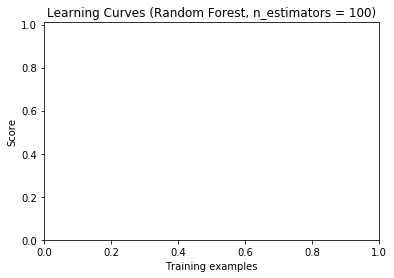

In [55]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


import matplotlib.pyplot as plt
title = "Learning Curves (Random Forest, n_estimators = 100)"
cv = cross_validation.ShuffleSplit(dataTrain.drop('Survived',1).shape[0], n_iter=10,test_size=0.3, random_state=0)
plot_learning_curve(RF, title, X_train, y_train, (0.0, 1.01), cv=cv, n_jobs=4)

plt.show()